In [1]:
import os

import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from chirho.dynamical.handlers import (DynamicIntervention, LogTrajectory,
                                       StaticBatchObservation,
                                       StaticIntervention)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

In [2]:
smoke_test = "CI" in os.environ
subset_starts = 420
subset_ends = 430 if smoke_test else 480
desired_frames = 500 if smoke_test else 900
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
num_steps = 10 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()

In [3]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 900
resulting_shape: (13500, 4)
min_time 1
max_time 900


In [4]:
object = loc_subset
rewards = object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
df = object.foragersDF
start, end, N_obs = min(df["time"]), max(df["time"]), len(df["time"].unique())

print(start, end, N_obs)

420 480 61


,x,y,time,state
313875,13.0,51.0,420,feed_l
313876,13.0,47.0,420,feed_l
313877,3.0,63.0,420,edge_l
313878,25.0,89.0,420,search_l
313879,19.0,48.0,420,feed_l


   x  y     state  time
0  0  0    edge_l   419
1  0  0    edge_r   419
2  0  0    feed_l   419
3  0  0    feed_r   419
4  0  0  search_l   419
5  0  0  search_r   419


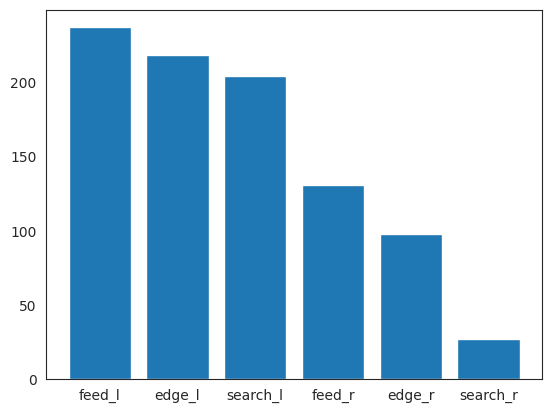

In [5]:
left_idx = rewards["x"].idxmin()
right_idx = rewards["x"].idxmax()
x_left = rewards.iloc[left_idx, 0]
y_left = rewards.iloc[left_idx, 1]

x_right = rewards.iloc[right_idx, 0]
y_right = rewards.iloc[right_idx, 1]

x_center = 50
y_center = 50


df_cat = ft.add_ring(
    df, "feed_l", x0=x_left, y0=y_left, outside_radius=10, inside_radius=0
)


df_cat = ft.add_ring(
    df_cat, "feed_r", x0=x_right, y0=y_right, outside_radius=10, inside_radius=0
)

df_cat = ft.add_ring(
    df_cat,
    "edge",
    x0=x_center,
    y0=y_center,
    outside_radius=51,
    inside_radius=47,
    divide_by_side=True,
)

df_cat = ft.add_ring(
    df_cat,
    "search",
    x0=x_center,
    y0=y_center,
    outside_radius=50,
    inside_radius=0,
    divide_by_side=True,
)


df_cat.drop(["forager", "type"], inplace=True, axis=1)

unique_states = set(df_cat["state"])


# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
initial_fake_positions = pd.DataFrame(
    {
        "x": [0] * len(unique_states),
        "y": [0] * len(unique_states),
        "state": sorted(list(unique_states)),
        "time": [(start - 1)] * len(unique_states),
    }
)

display(df_cat.head())

print(initial_fake_positions)

plt.bar(df_cat["state"].value_counts().index, df_cat["state"].value_counts())

df_cat_vis = pd.concat([initial_fake_positions, df_cat])
object.foragersDF = df_cat_vis

In [6]:
ft.animate_foragers(
    loc_subset,
    # loc_all,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    color_by_state=True,
)

In [7]:
all_states = df_cat["state"].unique()
times = sorted(df_cat["time"].unique())
all_combinations = pd.DataFrame(
    [(state, time) for state in all_states for time in times],
    columns=["state", "time"],
)
counts = pd.merge(
    all_combinations,
    df_cat.groupby(["state", "time"]).size().reset_index(name="count"),
    how="left",
    on=["state", "time"],
)
counts["count"].fillna(0, inplace=True)

count_data = {}
for state in unique_states:
    count_data[f"{state}_obs"] = torch.tensor(counts[counts["state"] == state]["count"].values)

shapes = [tensor.shape for tensor in count_data.values()]
assert all(shape == shapes[0] for shape in shapes)


tensor_length = len(next(iter(count_data.values())))

assert N_obs == tensor_length, "Tensor length does not match number of observations!"

sums_per_position = [
    sum(count_data[state][k] for state in count_data) for k in range(tensor_length)
]
assert all(
    sums_per_position[0] == sum_at_k for sum_at_k in sums_per_position[1:]
), "Population count is not constant!"

init_state = {key[:-4]: count_data[key][0] for key in count_data.keys()}

print(init_state)


{'search_l': tensor(3., dtype=torch.float64), 'search_r': tensor(0., dtype=torch.float64), 'feed_r': tensor(3., dtype=torch.float64), 'feed_l': tensor(3., dtype=torch.float64), 'edge_r': tensor(0., dtype=torch.float64), 'edge_l': tensor(6., dtype=torch.float64)}


In [8]:
def moving_average(data, window_size):
    cumsum = torch.cumsum(data, dim=0)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1 :] / window_size


def plot_trajectories(data, times, window_size, title = "Counts", 
                      scatter_data = None, scatter_data_type = None, observed = False):
    
    keys = ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"]
    observed_keys = [f"{key}_obs" for key in keys]
    colors = ["green", "darkgreen", "red", "darkred", "orange", "darkorange"]

    
    used_keys = observed_keys if observed else keys
    for state, color in zip(used_keys, colors):
        if window_size == 0:
           sns.lineplot(x=times, y=data[state], label=f"{state}", color=color)
           plt.title(title)
        else:
            running_averages = { state: moving_average(data[state].float(), window_size)
                            for state in data}
            sns.lineplot(x=times[window_size - 1 :],
                        y=running_averages[state],
                        label=f"{state} (avg)",
                        color=color,
                     )
            plt.title(f"{title} (running average, window size = {window_size})")
        
    if scatter_data is not None:
        for state, color in zip(observed_keys, colors):
            sns.scatterplot(
            x=times,
            y=scatter_data[state],
            label= f"{state} - {scatter_data_type}",
            color=color,
            )

        # plt.xlim(start, end)
    plt.xlabel("time (frames)")
    plt.ylabel("# of locust")
    plt.legend(loc="upper right", fontsize="x-small")
    sns.despine()



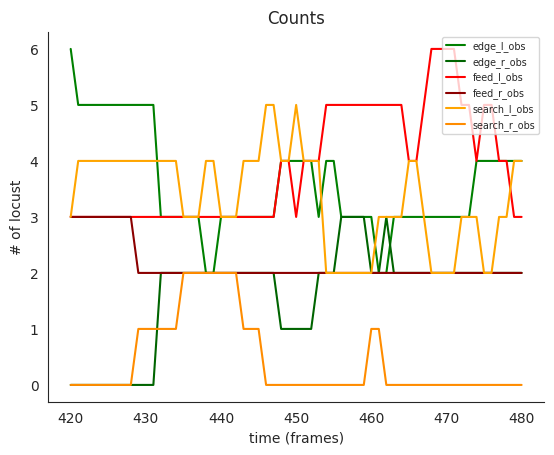

In [9]:
plot_trajectories(count_data, times, window_size=0, observed = True)


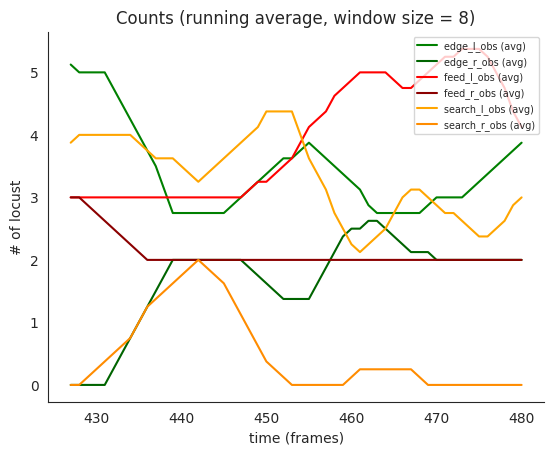

In [10]:
plot_trajectories(count_data, times, window_size=8, observed=True)

In [11]:
true_wonder = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
w_ee, w_es, w_se, w_sf, w_ss,  = torch.unbind(true_wonder)

true_attraction = torch.tensor([0.01, 0.01, 0.02, 0.02, 0.04, 0.01, 0.01])
a_eler, a_erel, a_es, a_se, a_f, a_slsr, a_srsl = torch.unbind(true_attraction)


class LocustDynamics(pyro.nn.PyroModule):
    def __init__(self, attraction, wonder):
        super().__init__()
        self.attraction = attraction
        self.wonder = wonder

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        
        dX["edge_l"] = (self.attraction[0] * X["edge_r"] * X["edge_l"] 
                        - self.wonder[0] * X["edge_l"] 
                        + self.wonder[0] * X["edge_r"]
                        - self.attraction[1] * X["edge_l"] * X["search_l"]
                        - self.attraction[3] * X["edge_l"] * X["feed_l"]
                        - self.wonder[2] * X["edge_l"]
                        + self.wonder[1] * X["search_l"]
                        )
                        
                        
        
        dX["edge_r"] = (- self.attraction[0] * X["edge_l"] * X["edge_r"]
                        + self.wonder[0] * X["edge_l"]
                        - self.wonder[0] * X["edge_r"]
                        - self.attraction[2] * X["edge_r"] * X["search_r"]
                        - self.attraction[4] * X["edge_r"] * X["feed_r"]
                        - self.wonder[2] * X["edge_r"]
                        )
                    
        
        dX["search_l"] =  (
            self.attraction[0] * X["search_r"] * X["search_l"]
            - self.wonder[0] * X["search_l"]
            + self.wonder[0] * X["search_r"]
            + self.attraction[1] * X["edge_l"] * X["search_l"]
            + self.attraction[3] * X["edge_l"] * X["feed_l"]
            + self.wonder[2] * X["edge_l"]
            - self.attraction[5] * X["search_l"] * X["feed_l"]
            - self.wonder[1] * X["search_l"]
            - self.wonder[2] *X["search_l"]
                     )

  
        dX["search_r"] =  (
            - self.attraction[0] * X["search_r"] * X["search_l"]
            - self.wonder[0] * X["search_r"]
            + self.wonder[0] * X["search_l"]
            + self.attraction[2] * X["edge_r"] * X["search_r"]
            + self.attraction[4] * X["edge_r"] * X["feed_r"]
            + self.wonder[2] * X["edge_r"]
            - self.attraction[6] * X["search_r"] * X["feed_r"]
            - self.wonder[1] * X["search_r"]
            - self.wonder[2] * X["search_r"]
                     )

        dX["feed_l"] = (self.attraction[5] * X["search_l"] * X["feed_l"]
                        + self.wonder[2] * X["search_l"] 
                        - self.wonder[1] * X["feed_l"]
                        )         

        dX["feed_r"] = (self.attraction[6] * X["search_r"] * X["feed_r"]
                        + self.wonder[2] * X["search_r"] 
                        - self.wonder[1] * X["feed_r"]
                        )             
        
        return dX
    
       
def locust_noisy_model(X: State[torch.Tensor]) -> None:
    event_dim = 1 if X["edge_l"].shape and X["edge_l"].shape[-1] > 1 else 0
    keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]
    for key in keys:
        pyro.sample(
            f"{key}_obs", dist.Poisson(X[key]).to_event(event_dim)
        )

ValueError: too many values to unpack (expected 5)

logging shape torch.Size([62])


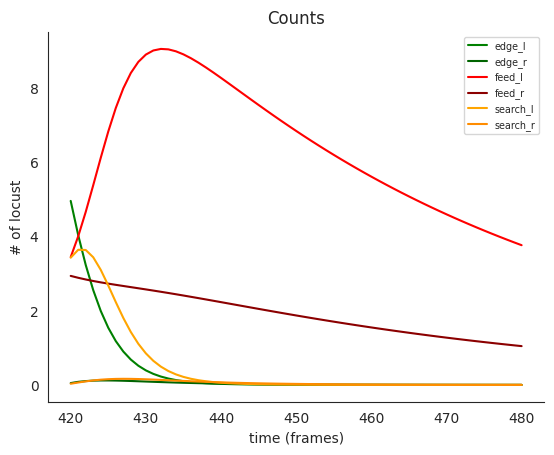

In [12]:
start_time = torch.tensor(start).float()
end_time = torch.tensor(end+2).float()
step_size = 1
logging_times = torch.arange(start_time, end_time, step_size)

print("logging shape", logging_times.shape)

#assert logging_times.squeeze().tolist() == times + 1

attraction_true = torch.tensor([0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04])
wonder_true = torch.tensor([0.01, 0.02, 0.03])


locust_true = LocustDynamics(attraction_true, wonder_true)


with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory

plot_trajectories(locust_true_traj, logging_times[:-1], window_size=0)

In [13]:
for _, tensor in locust_true_traj.items():
    assert torch.all(tensor >= 0)
        #locust_true_traj[key] = torch.clamp(tensor, min=0)

with pyro.poutine.trace() as tr:
    locust_noisy_model(locust_true_traj)

keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]
observed_keys = [f"{key}_obs" for key in keys]

synthetic_data = dict(**{k: tr.trace.nodes[k]["value"] for k in observed_keys})

assert count_data.keys() == synthetic_data.keys()

assert count_data["edge_l_obs"].shape == synthetic_data["edge_l_obs"].shape, f"count: {count_data['edge_l_obs'].shape}, synthetic: {synthetic_data['edge_l_obs'].shape}"


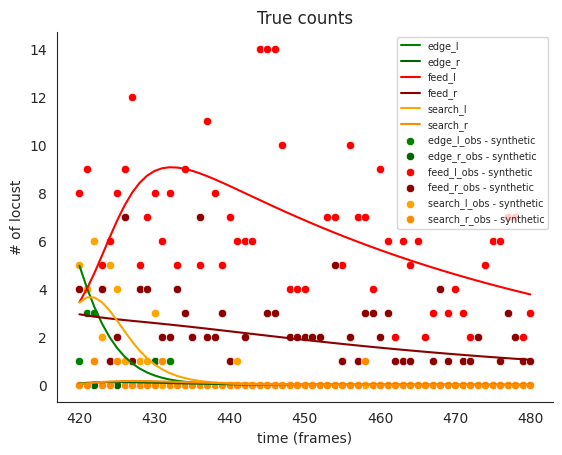

In [15]:
plot_trajectories(locust_true_traj, times, window_size=0, title="True counts",
                  scatter_data=synthetic_data, scatter_data_type="synthetic")

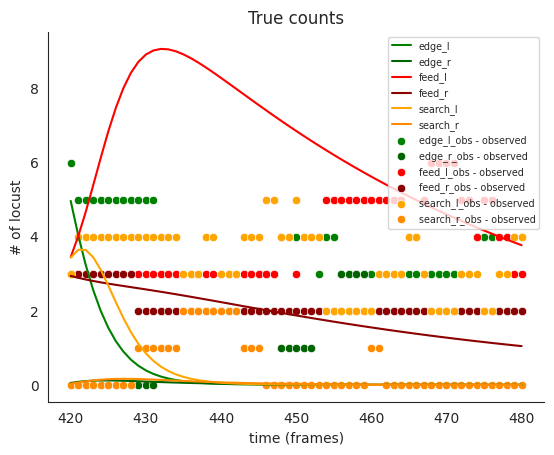

In [16]:
plot_trajectories(locust_true_traj, times, window_size=0, title="True counts",
                  scatter_data=count_data, scatter_data_type="observed")

In [26]:
def bayesian_locust(base_model=LocustDynamics) -> Dynamics[torch.Tensor]:
    
    with pyro.plate("attr", size=7):
        attraction = pyro.sample("attraction", dist.Uniform(0,0.1))
    with pyro.plate("wond", size=3):
        wonder = pyro.sample("wonder", dist.Uniform(0, .1))

    locust_model = base_model(attraction, wonder)
    return locust_model


def simulated_bayesian_locust(
    init_state, start_time, logging_times, base_model=LocustDynamics
) -> State[torch.Tensor]:
    locust_model = bayesian_locust(base_model)
    with TorchDiffEq(), LogTrajectory(logging_times) as lt:  #, is_traced=True is unexpected keyword?
        simulate(locust_model, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [24]:
prior_predictive = Predictive(simulated_bayesian_locust, num_samples=10)
locust_prior_samples = prior_predictive(init_state, start_time, logging_times)

AssertionError: underflow in dt 2.5669613003574758e-14

In [64]:
def locust_uncertainty_plot(
    time, state_pred, ylabel, color, ax, mean_label="posterior mean"
):

    sns.lineplot(
        x=time,
        y=state_pred.mean(dim=0).squeeze().tolist(),
        color=color,
        label=mean_label,
        ax=ax,
    )
    #95% Credible Interval
    ax.fill_between(
        time,
        torch.quantile(state_pred, 0.025, dim=0).squeeze(),
        torch.quantile(state_pred, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
        label="95% credible interval",
    )

    ax.set_xlabel("time")
    ax.set_ylabel(ylabel)

def locust_data_plot(time, data, data_label, ax):
    sns.lineplot(
        x=time, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )

def locust_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="measurement period"
    )
    ax.axvline(test_end_time, color="black", linestyle=":")


def locust_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=start_time,
    test_end_time=start_time,
    mean_label="posterior mean",
):
    locust_uncertainty_plot(
        time_period, state_pred, ylabel, color, ax, mean_label=mean_label
    )
    locust_data_plot(time_period, data, data_label, ax)
    if test_plot:
        locust_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

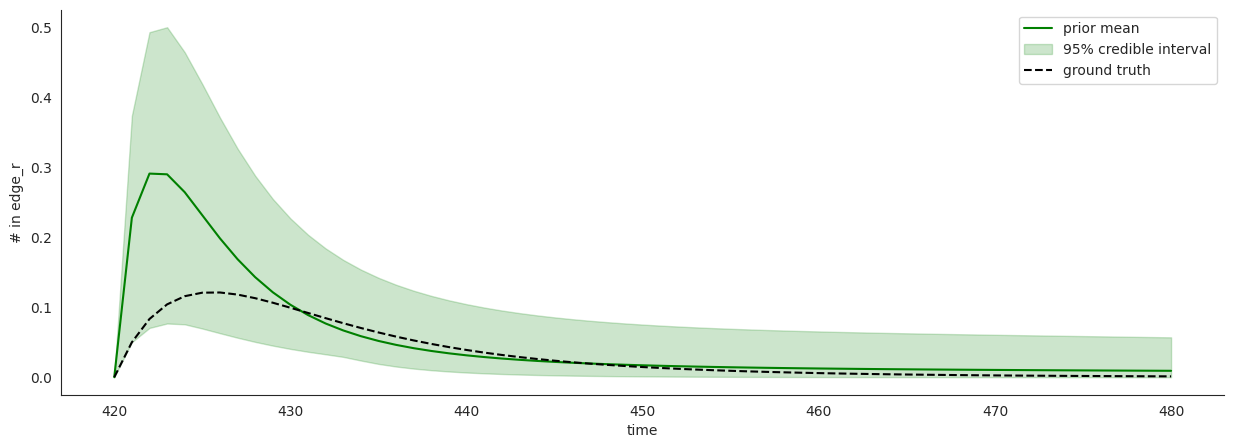

In [65]:
state = "edge_r"
color = "green"

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

locust_plot(
        logging_times,
        locust_prior_samples[state],
        locust_true_traj[state],
        f"# in {state}",
        color,
        "ground truth",
        ax,
        legend=True,
        test_plot=False,
        mean_label="prior mean",
        )



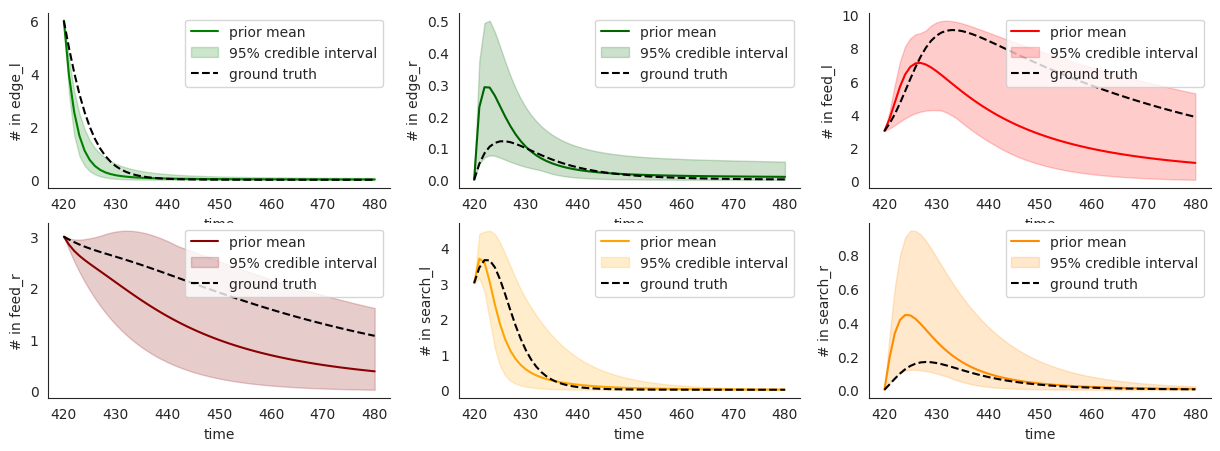

In [66]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

ax = ax.flatten()

for i, state, color in zip(range(6),
        ["edge_l", "edge_r", "feed_l", "feed_r", "search_l", "search_r"],
        ["green", "darkgreen", "red", "darkred", "orange", "darkorange"],
    ):
        locust_plot(
        logging_times,
        locust_prior_samples[state],
        locust_true_traj[state],
        f"# in {state}",
        color,
        "ground truth",
        ax[i],
        legend=True,
        test_plot=False,
        mean_label="prior mean",
        )


In [68]:
def conditioned_locust(
    obs_times, data, init_state, start_time, base_model=LocustDynamics
) -> None:
    sir = bayesian_locust(base_model)
    obs = condition(data=data)(locust_noisy_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])


def run_svi_inference(
    model,
    num_steps=num_steps,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [69]:
sir_guide = run_svi_inference(
    conditioned_locust,
    num_steps=num_steps,
    obs_times=logging_times,
    data=synthetic_data,
    init_state=init_state,
    start_time=start_time,
)

ValueError: Continuous inference cannot handle discrete sample site 'edge_r_obs'. Consider enumerating that variable as documented in https://pyro.ai/examples/enumeration.html . If you are already enumerating, take care to hide this site when constructing an autoguide, e.g. guide = AutoNormal(poutine.block(model, hide=['edge_r_obs'])).
Trace Shapes:
 Param Sites:
Sample Sites: